## `5_taichi.ipynb`

In [1]:
import copy
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"
import taichi as ti
import numpy as np
from IPython.display import Markdown as md

[Taichi] version 1.6.0, llvm 16.0.0git, commit f1c6fbbd, linux, python 3.9.4


[I 09/10/23 18:38:37.194 15470] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [2]:
from common import initialize_field, plot_field, save_result, compare_results, read_results

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

From Taichi documentation:

> Taichi is embedded in Python and uses modern just-in-time (JIT) frameworks (for example LLVM, SPIR-V) to offload the Python source code to native GPU or CPU instructions, offering the performance at both development time and runtime.

Like Numba, Taichi is a very big module, with special solutions to graphic visualization, spatially sparse data processing and deep learning. Here we only focus on its basic application and compare its performance with NumPy. 

## Pointwise Stencil

The first thing we need to do here is to initiate the Taichi kernel, with which the backend and the default data type can be defined. We will first start with x64 CPUs.

### CPU backend

In [4]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


Then we accelerate the array for-loop code with Taichi using the `@ti.kernel` decorator. Similar to Gt4Py, we have to predefine the datatype of the variables, here `ti.types.ndarray`, so that NumPy arrays can be accepted. We can also define functions only usable by `kernel` with `@ti.func` decorator. However, as mentioned in their docs:

> In Taichi, a kernel is allowed to have a maximum of one return value, which could either be a scalar, `ti.types.matrix()`, or `ti.types.vector()`.

Therefore, we cannot directly return our 3D fields. Moreover, we cannot easily swap two arrays by just exchanging their pointers as we did previously with `in_field, out_field = out_field, in_field`. The reason is also explained in their docs:

> Direct value assignments lead to semantic ambiguity. For example, a = b can mean data copy if a is pre-defined, or otherwise can serve to define and initialize a.

However, the supported `ti.copy_from()` command will be even slower as it copies value-by-value on the memory level. Therefore, the best approach is to swap the fields outside the Taichi kernel.

In [5]:
@ti.kernel
def taichi_ndarray_equal_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k in range(NZ):  # Will be parallelized
        for j in range(NY):
            for i in range(NX):
                out_field[k, j, i] = in_field[k, j, i]
                # taichi doesn't support an ndarray output, so there's no return value

def taichi_ndarray_pointwise(in_field, out_field):  # There's no easy copying for ti.ndarray, so we do that outside kernel
    for n in range(N_ITER):
        taichi_ndarray_equal_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

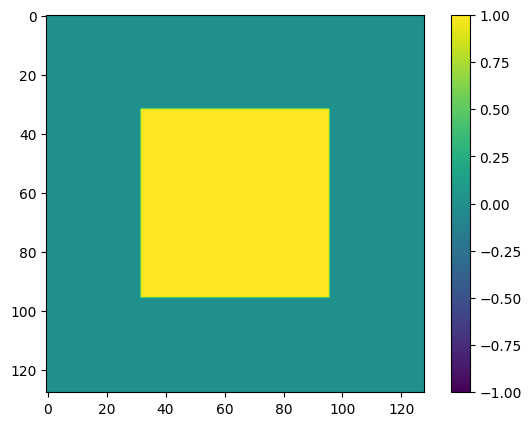

In [6]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_pointwise(in_field, out_field)
plot_field(out_field)

In [7]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_pointwise(in_field, out_field)

115 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 115 ms ± 914 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [8]:
result_taichi_ndarray_cpu_pointwise = _
save_result(result_taichi_ndarray_cpu_pointwise, "taichi_ndarray_cpu_pointwise")

In [9]:
time_list_pointwise = read_results("list_pointwise")

ti_vs_list = compare_results(result_taichi_ndarray_cpu_pointwise.average, time_list_pointwise, "faster")

md(f"""
The Taichi code is **{ti_vs_list} times faster than pure Python**. However, NumPy and other DSL code are much faster,
maybe because Taichi is poor at copying between objects.
""")


The Taichi code is **~72 times faster than pure Python**. However, NumPy and other DSL code are much faster,
maybe because Taichi is poor at copying between objects.


Taichi manages parallel for-loops using multiple cores in a somewhat rigid way: only the outermost layer for-loop will be run parallelly, which is automatic and needs an extra code `ti.loop_config(serialize=True)` to prevent it. In this pointwise copying case we can involve all three dimensions `i`, `j` and `k` into parallel computation, and Taichi allows that with `ti.ndrange()` command to loop over the whole data field.

In [10]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for k, j, i in ti.ndrange(NZ, NY, NX):  # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

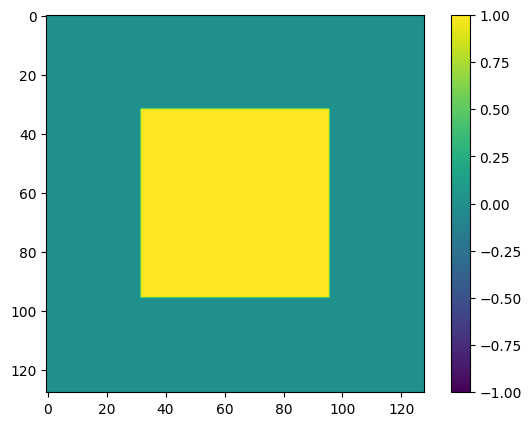

In [11]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)
plot_field(out_field)

In [12]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)

45.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 45.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [13]:
result_taichi_ndarray_parallel_cpu_pointwise = _
save_result(result_taichi_ndarray_parallel_cpu_pointwise, "taichi_ndarray_parallel_cpu_pointwise")

In [14]:
ti_parallel_vs_ti = compare_results(
    result_taichi_ndarray_parallel_cpu_pointwise.average,
    result_taichi_ndarray_cpu_pointwise.average,
    "faster"
)

md(f"""
With a more parallel for-loop we see that it becomes **{ti_parallel_vs_ti} times faster than the original ones with 
parallelization only on Z dimension**, as it fully exploits each core and assigns their workloads better. This leads to an 
interesting question if the sequence of `ti.ndrange` affects the overall performance.
""")


With a more parallel for-loop we see that it becomes **~2.6 times faster than the original ones with 
parallelization only on Z dimension**, as it fully exploits each core and assigns their workloads better. This leads to an 
interesting question if the sequence of `ti.ndrange` affects the overall performance.


In [15]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_XYZ_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for i, j, k in ti.ndrange(NX, NY, NZ):  # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_XYZ_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

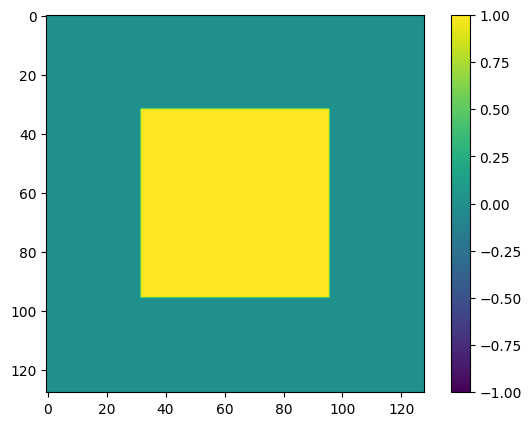

In [16]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)
plot_field(out_field)

In [17]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_XYZ_pointwise(in_field, out_field)

108 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


And it does! It seems like the `ti.ndrange` sequence decides the actual for-loop sequence and it does not optimize according to the array memory layout, which we have already discussed in the [previous Notebook](./1_lists_numpy.ipynb). According to this optimizing result, **we will always use the parallel for-loop in the code of the following parts**.

Next, let's switch the array datatype from `ndarray` to `ti.field`, as is mentioned in their docs:

> Fields in Taichi are the global data containers, which can be accessed from both the Python scope and the Taichi scope. Just like an ndarray in NumPy or a tensor in PyTorch, a field in Taichi is defined as a multi-dimensional array of elements, and elements in a field can be a Scalar, a Vector, a Matrix, or a Struct.

Here `Struct` is a group of variables, just like in C++. Concepts like vector fields and matrix fields are frequently used in physical simulation. Therefore, this instruction hints that `ti.field` is better at this task.

This message also gives another hint that it would be better for `ti.field` to be global variables, which is actually the common workflow of Taichi. This, however, brings another problem.

> In Taichi, a kernel treats global variables as compile-time constants. This means that it takes in the current values of the global variables at the time it is compiled and does not track changes to them afterwards.

Therefore, if we want to operate on `ti.field` using kernels, we can only use them once in the code. In our case, whenever we want to run the kernel on a different input, we have to recompile the kernel by initializing Taichi again to update global variables.

One more thing worth noticing is that `ti.field`, again, does not support swapping. So we are forced to use `ti.field.copy_from()` as we did before.

Now, let's change the datatype from `ti.ndarray` to `ti.field` and see how it goes:

In [18]:
@ti.kernel
def taichi_field_equal_more_parallel_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX):  # Will be parallelized
        out_field[k, j, i] = in_field[k, j, i]

def taichi_field_more_parallel_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

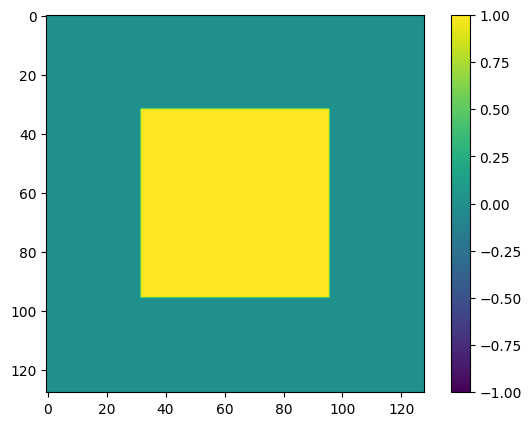

In [19]:
field = initialize_field(NX, NY, NZ, mode="square")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))  # first initialize ti.field
in_field.from_numpy(field)  # then fill the field with the np.ndarray
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy() # return the field back to np.ndarray
plot_field(out_field)

In [20]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)

62.3 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 62.3 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [21]:
result_taichi_field_parallel_cpu_pointwise = _
save_result(result_taichi_field_parallel_cpu_pointwise, "taichi_field_parallel_cpu_pointwise")

The `ti.field` version is actually slower than the `ti.ndarray` version. This might be mainly because of the lagging of `copy_from` function.

Now let's inspect sine calculation pointwise. Taichi provides the sine function `ti.sin()` that can be implemented on scalars. We will check the ndarray version and the field version respectively.

In [22]:
@ti.kernel
def taichi_ndarray_equal_more_parallel_sin_pointwise(
    in_field: ti.types.ndarray(dtype=ti.f64, ndim=3),
    out_field: ti.types.ndarray(dtype=ti.f64, ndim=3)
):
    for i, j, k in ti.ndrange(NX, NY, NZ):  # Will be parallelized
        out_field[k, j, i] = ti.sin(in_field[k, j, i])

def taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_ndarray_equal_more_parallel_sin_pointwise(in_field, out_field)
        if n < N_ITER - 1:
            in_field, out_field = out_field, in_field
    return out_field

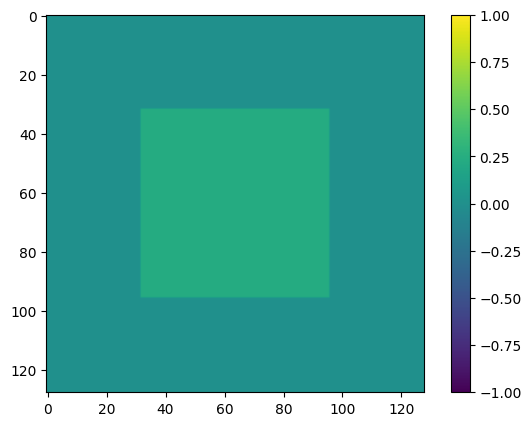

In [23]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [24]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)

253 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 253 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
result_taichi_ndarray_parallel_cpu_sin_pointwise = _
save_result(result_taichi_ndarray_parallel_cpu_sin_pointwise, "taichi_ndarray_parallel_cpu_sin_pointwise")

In [26]:
@ti.kernel
def taichi_field_equal_more_parallel_sin_pointwise():
    for k, j, i in ti.ndrange(NZ, NY, NX):
        out_field[k, j, i] = ti.sin(in_field[k, j, i])

def taichi_field_more_parallel_sin_pointwise(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_equal_more_parallel_sin_pointwise()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

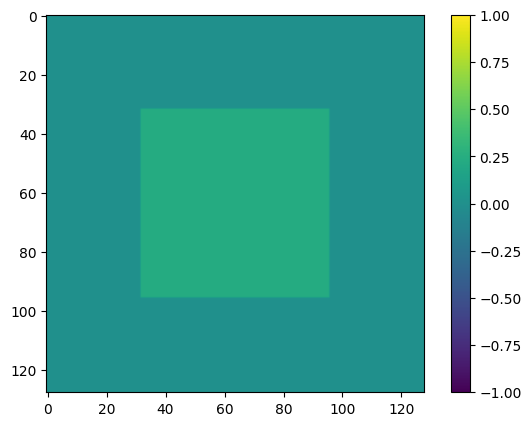

In [27]:
field = initialize_field(NX, NY, NZ, mode="square")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [28]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_sin_pointwise(in_field, out_field)

76.2 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 76.2 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [29]:
result_taichi_field_parallel_cpu_sin_pointwise = _
save_result(result_taichi_field_parallel_cpu_sin_pointwise, "taichi_field_parallel_cpu_sin_pointwise")

In [30]:
time_list_sin_pointwise = read_results("list_sin_pointwise")
time_array_sin_pointwise = read_results("array_sin_pointwise")
time_numpy_sin_pointwise = read_results("numpy_sin_pointwise")
ti_ndarray_vs_lists = compare_results(result_taichi_ndarray_parallel_cpu_sin_pointwise.average, time_list_sin_pointwise, "faster")
ti_field_vs_ti_ndarray = compare_results(
    result_taichi_field_parallel_cpu_sin_pointwise.average,
    result_taichi_ndarray_parallel_cpu_sin_pointwise.average,
    "faster"
)
ti_ndarray_vs_numpy = compare_results(result_taichi_ndarray_parallel_cpu_sin_pointwise.average, time_numpy_sin_pointwise,"faster")

md(f"""
For the sine stencil, Taichi code using `ti.ndarray` is **{ti_ndarray_vs_lists} times faster than pure Python code (lists)** and 
**{ti_ndarray_vs_numpy} times faster than vectorized NumPy arrays**. By applying `ti.field` instead of `ti.ndarray`, the code 
speed can be even **{ti_field_vs_ti_ndarray} times faster**, comparable to Numba and NumExpr. `ti.field` now seems to gain enough 
advantages over `ti.ndarray` to overcome the `copy_from` lagging by optimizing sine calculation.
""")


For the sine stencil, Taichi code using `ti.ndarray` is **~57 times faster than pure Python code (lists)** and 
**~3.5 times faster than vectorized NumPy arrays**. By applying `ti.field` instead of `ti.ndarray`, the code 
speed can be even **~3.3 times faster**, comparable to Numba and NumExpr. `ti.field` now seems to gain enough 
advantages over `ti.ndarray` to overcome the `copy_from` lagging by optimizing sine calculation.


Now let's check if the stencil runs even faster on GPU backends.

### GPU backend

Before applying GPU acceleration we first check our GPU information.

In [31]:
!nvidia-smi

Sun Sep 10 18:39:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   23C    P0    25W / 250W |      0MiB / 16280MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

One advantage of using Taichi is that the backend switching is convenient. With a simple `ti.init(arch=ti.gpu)` we can reinitiate the Taichi kernal to the GPU backend.

In [32]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


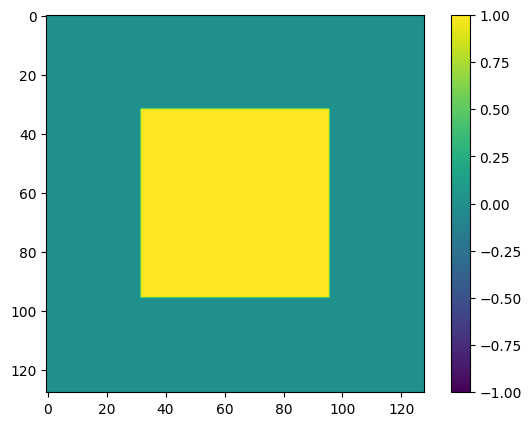

In [33]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_pointwise(in_field, out_field)
plot_field(out_field)

In [34]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_pointwise(in_field, out_field)

439 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


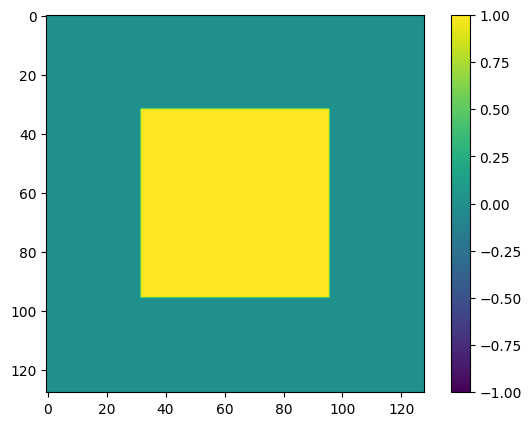

In [35]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)
plot_field(out_field)

In [36]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_pointwise(in_field, out_field)

254 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 254 ms ± 475 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [37]:
result_taichi_ndarray_parallel_gpu_pointwise = _
save_result(result_taichi_ndarray_parallel_gpu_pointwise, "taichi_ndarray_parallel_gpu_pointwise")

In [38]:
md(f"""
When dealing with `ti.ndarray`, CUDA backend is even slower than x64 CPUs 
({result_taichi_ndarray_parallel_cpu_pointwise.average * 1e3:.1f}ms when running parallel).
It seems that Taichi does not optimize the `ti.ndarray` operation on GPU backend.
""")


When dealing with `ti.ndarray`, CUDA backend is even slower than x64 CPUs 
(45.1ms when running parallel).
It seems that Taichi does not optimize the `ti.ndarray` operation on GPU backend.


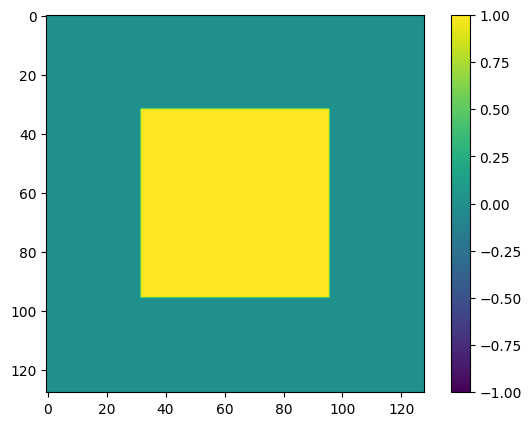

In [39]:
field = initialize_field(NX, NY, NZ, mode="square")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))  # first initialize ti.field
in_field.from_numpy(field)  # then fill the field with the np.ndarray
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)
out_field = out_field.to_numpy()  # return the field back to np.ndarray
plot_field(out_field)

In [40]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_pointwise(in_field, out_field)

24.1 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 24.1 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [41]:
result_taichi_field_parallel_gpu_pointwise = _
save_result(result_taichi_field_parallel_gpu_pointwise, "taichi_field_parallel_gpu_pointwise")

In [42]:
ti_gpu_vs_ti_cpu = compare_results(
    result_taichi_field_parallel_gpu_pointwise.average,
    result_taichi_ndarray_parallel_cpu_pointwise.average,
    "faster"
)

ti_field_vs_ti_ndarray = compare_results(
    result_taichi_field_parallel_gpu_pointwise.average,
    result_taichi_ndarray_parallel_gpu_pointwise.average,
    "faster"
)

md(f"""
When it comes to the `ti.field` version, GPU backend boosts the performance and it is **{ti_gpu_vs_ti_cpu} times faster than the CPU 
version**, and **{ti_field_vs_ti_ndarray} times faster than the `ti.ndarray` version on GPU**. This speed is comparable to other 
DSLs. `ti.field` seems to be the best format for Taichi GPU acceleration.
""")


When it comes to the `ti.field` version, GPU backend boosts the performance and it is **~1.9 times faster than the CPU 
version**, and **~11 times faster than the `ti.ndarray` version on GPU**. This speed is comparable to other 
DSLs. `ti.field` seems to be the best format for Taichi GPU acceleration.


In [43]:
time_array_pointwise = read_results("array_pointwise")
time_numpy_pointwise = read_results("numpy_pointwise")
time_numba_parallel_pointwise = read_results("numba_parallel_pointwise")
time_gt4py_numpy_pointwise = read_results("gt4py_numpy_pointwise")
time_numexpr_pointwise =  read_results("numexpr_pointwise")

md(f"""
| Function                                     | Time                                                                |
|:---------------------------------------------|--------------------------------------------------------------------:|
| `list_pointwise()`                           |  {time_list_pointwise}s                                             |
| `array_pointwise()`                          |  {time_array_pointwise}s                                            |
| `numpy_pointwise()`                          |  {time_numpy_pointwise * 1e6:.1f}μs                                 |
| `numba_parallel_pointwise()`                 |  {time_numba_parallel_pointwise * 1e3:.1f}ms                        |
| `gt4py_numpy_pointwise()`                    |  {time_gt4py_numpy_pointwise * 1e3:.1f}ms                           |
| `numexpr_pointwise()`                        |  {time_numexpr_pointwise * 1e3:.1f}ms                               |
| `taichi_ndarray_cpu_pointwise()`             |  {result_taichi_ndarray_cpu_pointwise.average * 1e3:.1f}ms          |
| `taichi_ndarray_parallel_cpu_pointwise()`    |  {result_taichi_ndarray_parallel_cpu_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_cpu_pointwise()`      |  {result_taichi_field_parallel_cpu_pointwise.average * 1e3:.1f}ms   |
| `taichi_ndarray_parallel_gpu_pointwise()`    |  {result_taichi_ndarray_parallel_gpu_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_gpu_pointwise()`      |  {result_taichi_field_parallel_gpu_pointwise.average * 1e3:.1f}ms   |
""")


| Function                                     | Time                                                                |
|:---------------------------------------------|--------------------------------------------------------------------:|
| `list_pointwise()`                           |  8.23s                                             |
| `array_pointwise()`                          |  15.1s                                            |
| `numpy_pointwise()`                          |  36.3μs                                 |
| `numba_parallel_pointwise()`                 |  3.3ms                        |
| `gt4py_numpy_pointwise()`                    |  2.9ms                           |
| `numexpr_pointwise()`                        |  12.0ms                               |
| `taichi_ndarray_cpu_pointwise()`             |  115.1ms          |
| `taichi_ndarray_parallel_cpu_pointwise()`    |  45.1ms |
| `taichi_field_parallel_cpu_pointwise()`      |  62.3ms   |
| `taichi_ndarray_parallel_gpu_pointwise()`    |  254.2ms |
| `taichi_field_parallel_gpu_pointwise()`      |  24.1ms   |


Now let's inspect sine calculation pointwise on GPU backend.

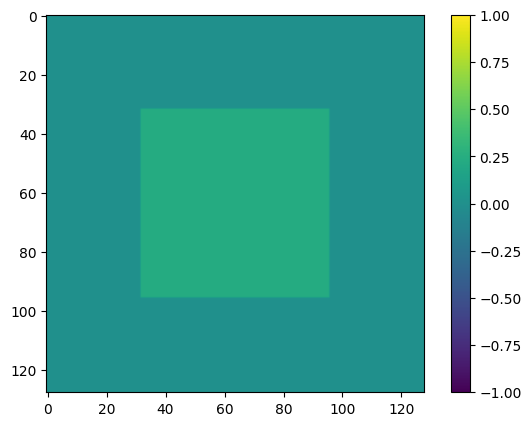

In [44]:
in_field = initialize_field(NX, NY, NZ, mode="square")
out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [45]:
%%timeit -o in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
out_field = taichi_ndarray_more_parallel_sin_pointwise(in_field, out_field)

262 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 262 ms ± 537 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [46]:
result_taichi_ndarray_parallel_gpu_sin_pointwise = _
save_result(result_taichi_ndarray_parallel_gpu_sin_pointwise, "taichi_ndarray_parallel_gpu_sin_pointwise")

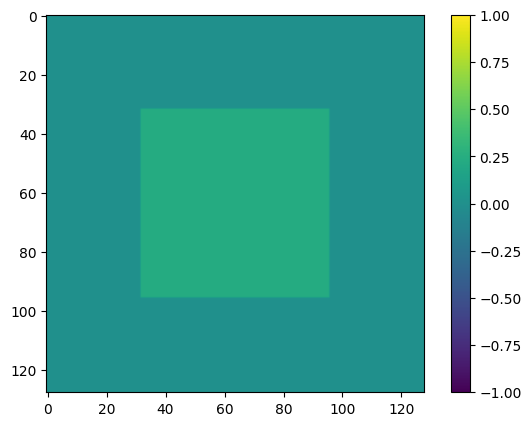

In [47]:
field = initialize_field(NX, NY, NZ, mode="square")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
taichi_field_more_parallel_sin_pointwise(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [48]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_more_parallel_sin_pointwise(in_field, out_field)

21.7 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 21.7 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [49]:
result_taichi_field_parallel_gpu_sin_pointwise = _
save_result(result_taichi_field_parallel_gpu_sin_pointwise, "taichi_field_parallel_gpu_sin_pointwise")

In [50]:
ti_gpu_vs_ti_cpu = compare_results(
    result_taichi_field_parallel_gpu_sin_pointwise.average,
    result_taichi_field_parallel_cpu_sin_pointwise.average,
    "faster"
)

md(f"""

For the sine stencil, the GPU backend is also **{ti_gpu_vs_ti_cpu} times faster than CPU with `ti.field` data container**, 
obtaining the fastest sin calculation speed so far, while the `ti.ndarray` version does not see much change compared to that with 
CPU backend.
""")



For the sine stencil, the GPU backend is also **~3.5 times faster than CPU with `ti.field` data container**, 
obtaining the fastest sin calculation speed so far, while the `ti.ndarray` version does not see much change compared to that with 
CPU backend.


In [51]:
time_numba_parallel_sin_pointwise = read_results("numba_parallel_sin_pointwise")
time_gt4py_ifirst_sin_pointwise = read_results("gt4py_ifirst_sin_pointwise")
time_numexpr_sin_pointwise =  read_results("numexpr_sin_pointwise")

md(f"""
| Function                                         | Time                                                                    |
|:-------------------------------------------------|------------------------------------------------------------------------:|
| `list_sin_pointwise()`                           |  {time_list_sin_pointwise}s                                             |
| `array_sin_pointwise()`                          |  {time_array_sin_pointwise}s                                            |
| `numpy_sin_pointwise()`                          |  {time_numpy_sin_pointwise * 1e3:.1f}ms                                 |
| `numba_parallel_sin_pointwise()`                 |  {time_numba_parallel_sin_pointwise * 1e3:.1f}ms                        |
| `gt4py_ifirst_sin_pointwise()`                   |  {time_gt4py_ifirst_sin_pointwise * 1e3:.1f}ms                          |
| `numexpr_sin_pointwise()`                        |  {time_numexpr_sin_pointwise * 1e3:.1f}ms                               |
| `taichi_ndarray_parallel_cpu_sin_pointwise()`    |  {result_taichi_ndarray_parallel_cpu_sin_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_cpu_sin_pointwise()`      |  {result_taichi_field_parallel_cpu_sin_pointwise.average * 1e3:.1f}ms   |
| `taichi_ndarray_parallel_gpu_sin_pointwise()`    |  {result_taichi_ndarray_parallel_gpu_sin_pointwise.average * 1e3:.1f}ms |
| `taichi_field_parallel_gpu_sin_pointwise()`      |  {result_taichi_field_parallel_gpu_sin_pointwise.average * 1e3:.1f}ms   |

""")


| Function                                         | Time                                                                    |
|:-------------------------------------------------|------------------------------------------------------------------------:|
| `list_sin_pointwise()`                           |  14.3s                                             |
| `array_sin_pointwise()`                          |  22.3s                                            |
| `numpy_sin_pointwise()`                          |  873.0ms                                 |
| `numba_parallel_sin_pointwise()`                 |  62.1ms                        |
| `gt4py_ifirst_sin_pointwise()`                   |  58.0ms                          |
| `numexpr_sin_pointwise()`                        |  86.7ms                               |
| `taichi_ndarray_parallel_cpu_sin_pointwise()`    |  252.7ms |
| `taichi_field_parallel_cpu_sin_pointwise()`      |  76.2ms   |
| `taichi_ndarray_parallel_gpu_sin_pointwise()`    |  262.4ms |
| `taichi_field_parallel_gpu_sin_pointwise()`      |  21.7ms   |



So which one do we choose as the data container between `ti.ndarray` and `ti.field`? Taichi docs actually gives us an answer:

> You can use fields as data containers in most cases. However, fields might have very complicated tree-structured layouts with even sparsity in them. It is hard for external libraries to interpret or use computed results stored in `ti.field` directly. An ndarray, however, always allocates a contiguous memory block to allow straightforward data exchange with external libraries.

In our case, Taichi data will not interact frequently with external code, so **let's stick to `ti.field` to get a better performance together with the GPU backend**.

## 1D Stencil

### Same Column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

Now we examine the performance of Taichi on accelerating 1D stencil.

#### CPU backend

In [52]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [53]:
@ti.kernel
def taichi_field_diff_1D_same_col():
    for k, j in ti.ndrange(NZ, NY):
        for i in range(NX-1):
            out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
        out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])

def taichi_field_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_diff_1D_same_col()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

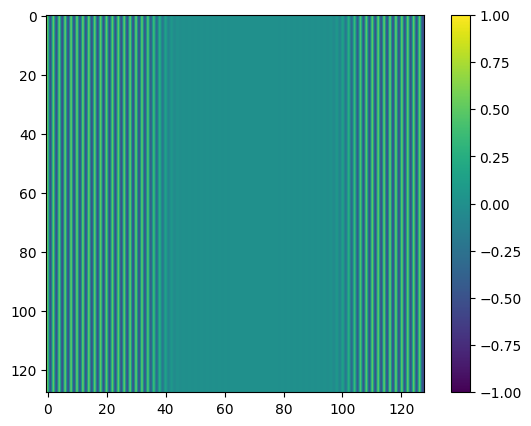

In [54]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [55]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)

63.5 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 63.5 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [56]:
result_taichi_cpu_1D_same_col = _
save_result(result_taichi_cpu_1D_same_col, "taichi_cpu_1D_same_col")

In [57]:
time_list_1D_same_col = read_results("list_1D_same_col_ZYX")
time_numpy_1D_same_col = read_results("numpy_1D_same_col")
time_numba_1D_same_col = read_results("numba_1D_same_col")
time_gt4py_1D_same_col = read_results("gt4py_kfirst_1D_same_col")
time_numexpr_1D_same_col = read_results("numexpr_1D_same_col")
ti_1D_col_vs_list_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_list_1D_same_col)
ti_1D_col_vs_numpy_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_numpy_1D_same_col, "faster-%")
ti_1D_col_vs_numexpr_1D_col = compare_results(result_taichi_cpu_1D_same_col.average, time_numexpr_1D_same_col, "faster-%")

md(f"""
The running time of Taichi accelerated code is **{ti_1D_col_vs_list_1D_col} times faster than pure Python code** 
and **{ti_1D_col_vs_numpy_1D_col} faster than the vectorized NumPy version**. Numba and GT4Py still perform much better (
{time_numba_1D_same_col * 1e3:.1f} ms and {time_gt4py_1D_same_col * 1e3:.1f} ms respectively), but it's also 
{ti_1D_col_vs_numexpr_1D_col} faster than NumExpr, thanks to both parallelization and JIT acceleration of Taichi.
""")


The running time of Taichi accelerated code is **~235 times faster than pure Python code** 
and **~70% faster than the vectorized NumPy version**. Numba and GT4Py still perform much better (
3.7 ms and 8.3 ms respectively), but it's also 
~54% faster than NumExpr, thanks to both parallelization and JIT acceleration of Taichi.


Similar to what was already mentioned [in the GT4Py notebook](./3_gt4py.ipynb), when converting from `np.ndarray` to `ti.field`, the memory layout changes to the same sequence. Different memory layout can be realized with `ti.root`. Below is an example:

[Taichi] Starting on arch=x64


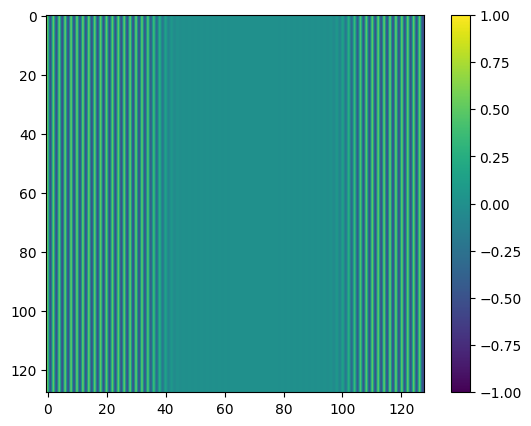

In [58]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
# Here we are calling the same function, so we reinitialize the kernel first
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(in_field) # Re-order the ti.field in ZYX sequence
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(out_field) # Same re-ordering
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [59]:
%%timeit field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(in_field); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.j, NY).dense(ti.k, NX).place(out_field); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)

61.4 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In the example above, the memory layout would be the same as a C-style layout: i-indices are continuous, then j-indices, and k-indices at last. And it turns out that the performance is similar to the version without `ti.root` settings.

Now let's try the other way round, i.e. a Fortran-style layout:

[Taichi] Starting on arch=x64


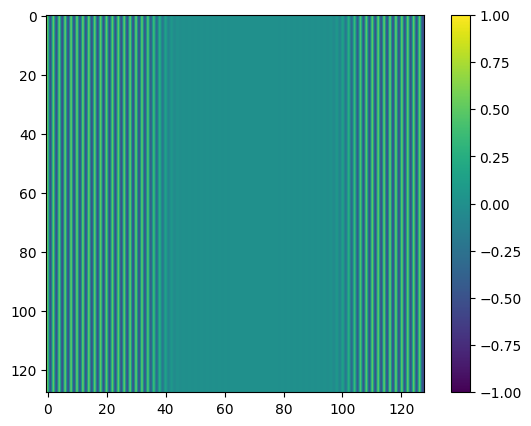

In [60]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
# Here we are calling the same function, so we reinitialize the kernel first
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(in_field) # Re-order the ti.field in XYZ sequence
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(out_field) # Same re-ordering
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [61]:
%%timeit field = field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(in_field); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.k, NX).dense(ti.j, NY).dense(ti.i, NZ).place(out_field); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)

162 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As expected, the run with Fortran-style memory layout is much slower because it doesn't fit the 1D stencil columnwise processing, as discussed in [the previous list and NumPy notebook](./1_lists_numpy.ipynb).

Now we inspect another data structure of Taichi: `Vector field`. In our case, it looks very promising that we define each row as a vector, and place each vector into a 2D `ti.field`, i.e. `field[k, j][i]`. We might be able to see a performance change with this data structure.

In [62]:
@ti.kernel
def taichi_vec_diff_1D_same_col():
    for k, j in ti.ndrange(NZ, NY):
        for i in range(NX-1):
            out_field[k, j][i] = 0.5 * (in_field[k, j][i+1] - in_field[k, j][i])
        out_field[k, j][NX-1] = 0.5 * (in_field[k, j][0] - in_field[k, j][NX-1])

def taichi_vec_1D_same_col(in_field, out_field):
    for n in range(N_ITER):
        taichi_vec_diff_1D_same_col()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

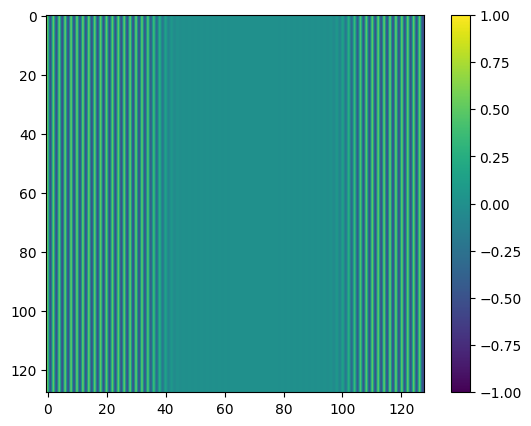

In [63]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
in_field.from_numpy(field)
out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_vec_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [64]:
%%timeit field = initialize_field(NX, NY, NZ); in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); in_field.from_numpy(field); out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_vec_1D_same_col(in_field, out_field)

61.9 ms ± 981 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And it turns out to be similar to the 3D `ti.field` result. However, this seems not to be a good way to manage the data according to the warning message that appears when we read in the element in vector field:

> Taichi matrices/vectors with 128x1 > 32 entries are not suggested. Matrices/vectors will be automatically unrolled at compile-time for performance. So the compilation time could be extremely long if the matrix size is too big. You may use a field to store a large matrix like this, e.g.: `x = ti.field(ti.f32, (128, 1))`.

This illustrates that vectors and matrices in Taichi are adviced to be small to fit in the cache and stay fast. Now let's see the performance with GPU backend.

#### GPU backend

In [65]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


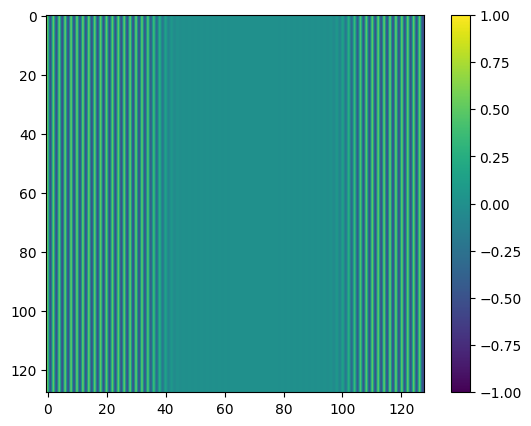

In [66]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [67]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_col(in_field, out_field)

21.8 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 21.8 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [68]:
result_taichi_gpu_1D_same_col = _
save_result(result_taichi_gpu_1D_same_col, "taichi_gpu_1D_same_col")

In [69]:
taichi_gpu_vs_taichi_cpu = compare_results(result_taichi_gpu_1D_same_col.average, result_taichi_cpu_1D_same_col.average)
taichi_gpu_vs_numpy = compare_results(result_taichi_gpu_1D_same_col.average, time_numpy_1D_same_col)

md(f"""
Under GPU backend the 1D stencil becomes **{taichi_gpu_vs_taichi_cpu} times faster than CPU backend**, or **{taichi_gpu_vs_numpy} 
times faster than NumPy solution**.
""")


Under GPU backend the 1D stencil becomes **~2.9 times faster than CPU backend**, or **~5.0 
times faster than NumPy solution**.


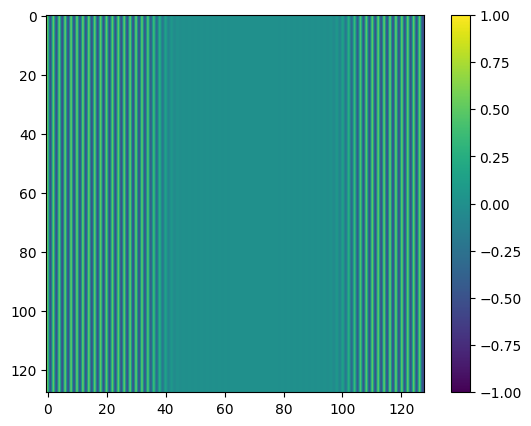

In [70]:
field = initialize_field(NX, NY, NZ, mode="vertical-bars")
in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
in_field.from_numpy(field)
out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_vec_1D_same_col(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [71]:
%%timeit field = initialize_field(NX, NY, NZ); in_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); in_field.from_numpy(field); out_field = ti.Vector.field(n=NX, dtype=ti.f64, shape=(NZ,NY)); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_vec_1D_same_col(in_field, out_field)

266 ms ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With GPU backend the Vector field attempt gets actually much slower, most possibly limited by cache usage. Considering the results above, **we will stick to the regular 3D field build-up for the following tests**.

In [72]:
md(f"""
| Function                      | Time                                                    |
|:------------------------------|--------------------------------------------------------:|
| `list_1D_same_col()`          |  {time_list_1D_same_col:.1f}s                           |
| `numpy_1D_same_col()`         |  {time_numpy_1D_same_col * 1e3:.0f}ms                   |
| `numba_1D_same_col()`         |  {time_numba_1D_same_col * 1e3:.1f}ms                   |
| `gt4py_kfirst_1D_same_col()`  |  {time_gt4py_1D_same_col * 1e3:.1f}ms                   |
| `numexpr_1D_same_col()`       |  {time_numexpr_1D_same_col * 1e3:.1f}ms                 |
| `taichi_cpu_1D_same_col()`    |  {result_taichi_cpu_1D_same_col.average * 1e3:.1f}ms    |
| `taichi_gpu_1D_same_col()`    |  {result_taichi_gpu_1D_same_col.average * 1e3:.1f}ms    |
""")


| Function                      | Time                                                    |
|:------------------------------|--------------------------------------------------------:|
| `list_1D_same_col()`          |  14.9s                           |
| `numpy_1D_same_col()`         |  108ms                   |
| `numba_1D_same_col()`         |  3.7ms                   |
| `gt4py_kfirst_1D_same_col()`  |  8.3ms                   |
| `numexpr_1D_same_col()`       |  97.8ms                 |
| `taichi_cpu_1D_same_col()`    |  63.5ms    |
| `taichi_gpu_1D_same_col()`    |  21.8ms    |


### Same Row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

#### CPU backend

In [73]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [74]:
@ti.kernel
def taichi_field_diff_1D_same_row():
    for k, i in ti.ndrange(NZ, NX):
        for j in range(NY-1):
            out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
        out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])

def taichi_field_1D_same_row(in_field, out_field):
    for n in range(N_ITER):
        taichi_field_diff_1D_same_row()
        if n < N_ITER - 1:
            in_field.copy_from(out_field)
    return out_field

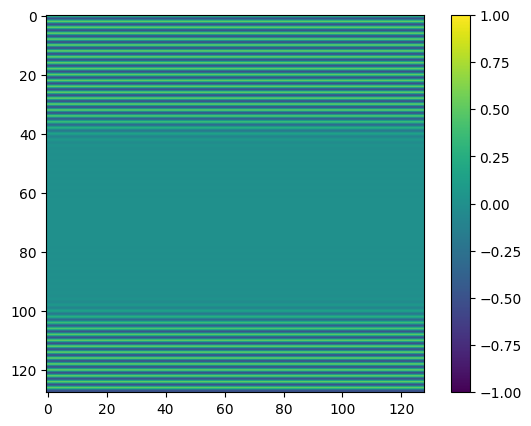

In [75]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [76]:
%%timeit field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
taichi_field_1D_same_row(in_field, out_field)

86.2 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


According to what we've learnt, the default `ti.field` memory layout is not optimized. Here using Taichi we can customize a `j-first` memory layout: j-indices are continous, and then i-indices, and k-indices at last. The field will use the same function(Taichi kernel here) without any further adjustment.

[Taichi] Starting on arch=x64


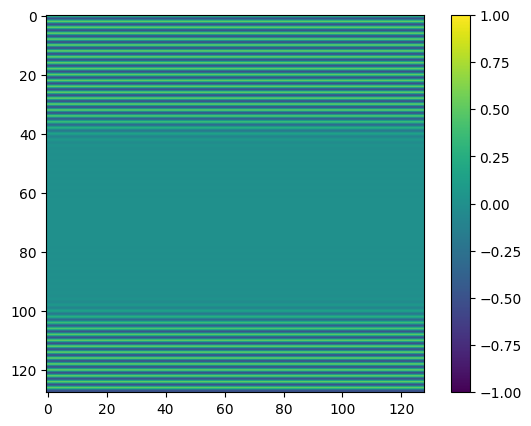

In [77]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field)
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field)
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [78]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_row(in_field, out_field)

62.6 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 62.6 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [79]:
result_taichi_cpu_1D_same_row = _
save_result(result_taichi_cpu_1D_same_row, "taichi_cpu_1D_same_row")

Yes! With this customized memory layout the stencils are even faster, similar to the column stencil result, proving that choosing the right memory layout is still relevant.

#### GPU backend

In [80]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


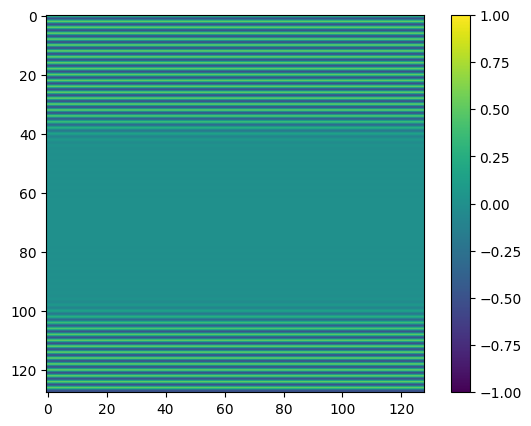

In [81]:
field = initialize_field(NX, NY, NZ, mode="horizontal-bars")
in_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field)
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64)
ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field)
out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_row(in_field, out_field)
out_field = out_field.to_numpy()
plot_field(out_field)

In [82]:
%%timeit -o field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(in_field); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64); ti.root.dense(ti.i, NZ).dense(ti.k, NX).dense(ti.j, NY).place(out_field); out_field.from_numpy(np.zeros_like(field))
out_field = taichi_field_1D_same_row(in_field, out_field)

22.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 22.3 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [83]:
result_taichi_gpu_1D_same_row = _
save_result(result_taichi_gpu_1D_same_row, "taichi_gpu_1D_same_row")

Here GPU shows similar acceleration we've seen for column stencil.

## 2D stencil

Writing a 2D stencil code using Taichi is mostly similar to writing a NumPy version, except that we cannot use the slicing indexing of arrays but only pointwise for-loops. Instead of using Python functions we use `ti.kernel` and `ti.func`. `ti.func` helps to organize the code in a more readable way, and will be fully inlined into the new functions or kernels when compiling, meaning that no overhead will be generated when calling `ti.func`. However, it can only be called by `ti.func` or `ti.kernel`. `ti.kernel`, on the other hand, cannot be called by other kernels or functions, and have certain limitations other than those mentioned before. For example, it is not possible to define fields or call the `copy_from()` function within a kernel. These limitations make the Taichi version the 2D stencil a bit tricky.

Just like previous DSLs, the performance of Taichi will be compared with the NumPy version from the course.

### CPU backend

First we work with a CPU backend.

In [84]:
ti.init(arch=ti.cpu, default_fp=ti.f64)

[Taichi] Starting on arch=x64


In [85]:
from stencil2d import laplacian, update_halo, apply_diffusion

Now we write Laplacian function with a `@ti.func` decorator.

In [86]:
@ti.func
def laplacian_taichi(in_field, lap_field, num_halo, extend=0):
    ib = num_halo - extend
    ie = NX - num_halo + extend
    jb = num_halo - extend
    je = NY - num_halo + extend
    
    for k, j, i in ti.ndrange(NZ,NY,NX):
        if ib <= i < ie and jb <= j < je:
            lap_field[k, j, i] = (
                -4.0 * in_field[k, j, i]
                + in_field[k, j, i - 1]
                + in_field[k, j, i + 1]
                + in_field[k, j - 1, i]
                + in_field[k, j + 1, i]
            )

# We define the kernal so that we can call it and compare its speed.
@ti.kernel
def laplacian_taichi_kernel():
    laplacian_taichi(in_field, out_field, 2)

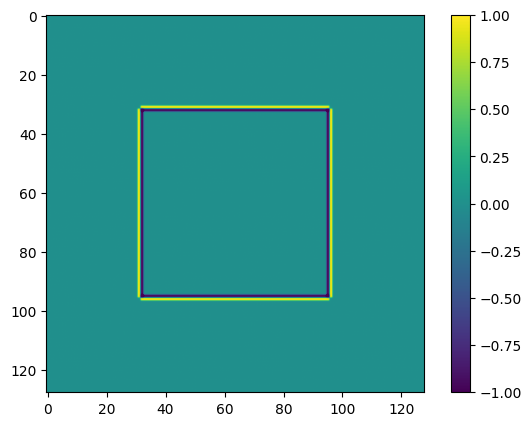

In [87]:
field = initialize_field(NX, NY, NZ, mode="square")
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(field)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros_like(field))
laplacian_taichi_kernel()
out_field = out_field.to_numpy()
plot_field(out_field)

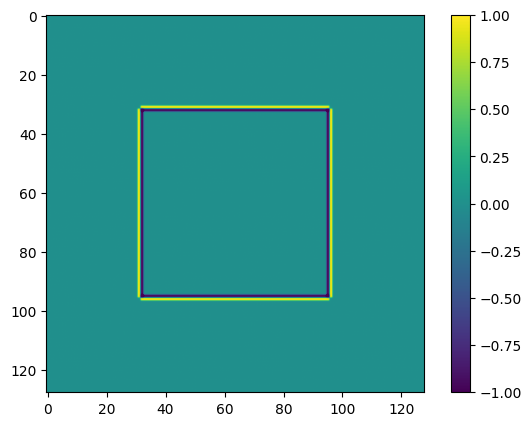

In [88]:
# Test if the laplacian works correctly.
in_field_2 = initialize_field(NX, NY, NZ, mode="square")
out_field_2 = np.zeros_like(in_field_2)
laplacian(in_field_2, out_field_2, num_halo=2)
plot_field(out_field_2)

In [89]:
np.array_equal(out_field, out_field_2)

True

In [90]:
%%timeit field = initialize_field(NX, NY, NZ); in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field.from_numpy(field); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(np.zeros_like(field))
laplacian_taichi_kernel()

854 µs ± 28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [91]:
%%timeit in_field = initialize_field(NX, NY, NZ); out_field = np.zeros_like(in_field)
laplacian(in_field, out_field, num_halo=2, extend=0)

7 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that the laplacian part is about 10 times faster with Taichi kernel compiling.

In [92]:
@ti.func
def update_halo_taichi(field, num_halo):
    for k, j, i in ti.ndrange(NZ, num_halo, NX - 2 * num_halo):
        # bottom and top edge (without corners)
        field[k, j, i + num_halo] = field[k, j + NY - 2 * num_halo, i + num_halo]
        field[k, j + NY - num_halo, i + num_halo] = field[k, j + num_halo, i + num_halo]
    
    for k, j, i in ti.ndrange(NZ, NY, num_halo):
        # left and right edge (including corners)
        field[k, j, i] = field[k, j, i + NX - 2 * num_halo]
        field[k, j, i + NX - num_halo] = field[k, j, i + num_halo]

@ti.kernel
def update_halo_taichi_kernel():
    update_halo_taichi(out_field, num_halo)

True

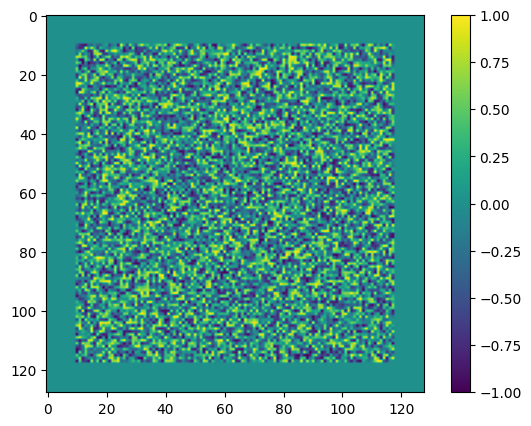

In [93]:
out_field_np = initialize_field(NX, NY, NZ, num_halo=10)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)
plot_field(out_field_np)
copy_out_field = out_field.to_numpy()
np.array_equal(out_field_np, copy_out_field)

False

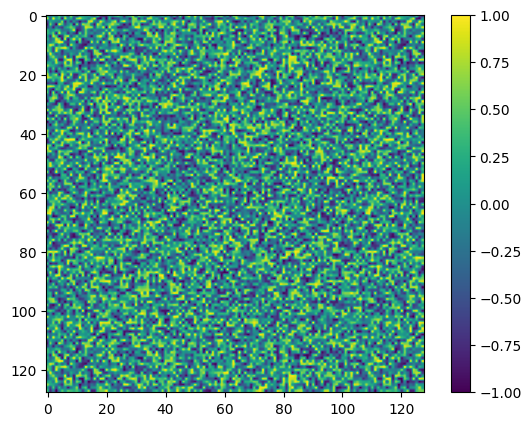

In [94]:
update_halo(out_field_np, num_halo=10)
plot_field(out_field_np)
np.array_equal(out_field_np, copy_out_field)

True

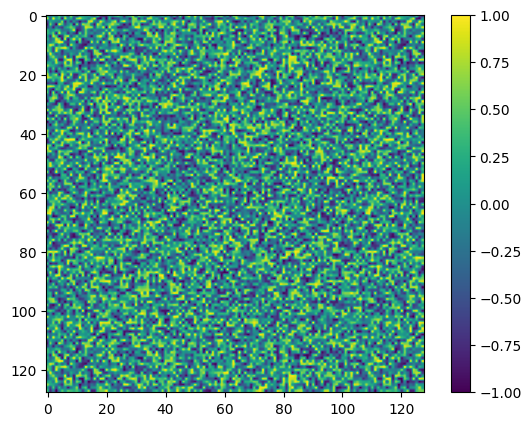

In [95]:
num_halo = 10
update_halo_taichi_kernel()
plot_field(out_field.to_numpy())
np.array_equal(out_field_np, out_field.to_numpy())

In [96]:
%%timeit in_field = initialize_field(NX, NY, NZ)
update_halo(in_field, num_halo=2)

638 µs ± 294 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [97]:
#timeit decorator seems to have a conflict with Taichi, so we split them to two blocks
ti.init(arch=ti.cpu, default_fp=ti.f64)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(initialize_field(NX, NY, NZ, num_halo=2))
num_halo = 2

[Taichi] Starting on arch=x64


In [98]:
%%timeit
update_halo_taichi_kernel()

162 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The halo update function also runs much faster with Taichi acceleration.

Now we compile one single `ti.kernel` called `diffusion_step_taichi()`, as calling multiple kernels drags down the overall speed with unnecessary overheads. Then we use a python function `apply_diffusion_taichi` to wrap it up with all the sections that cannot be operated inside `ti.kernel`. In the end we also need to include `update_halo_taichi` function again, so we compile the `ti.func` into `ti.kernel`.

In [99]:
@ti.kernel
def diffusion_step_taichi():
    alpha = 1.0 / 32.0
    # Periodic boundary conditions are achieved updating the halo region before applying the diffusion operator
    update_halo_taichi(in_field, num_halo)
    
    # 4th-order diffusion operator (spatial update)
    for k, j, i in ti.ndrange(NZ, NY, NX):
        if num_halo <= i < NX - num_halo and num_halo <= j < NY - num_halo:
            out_field[k, j, i] = 20 * in_field[k, j, i] \
                - 8 * (in_field[k, j, i+1] + in_field[k, j, i-1] + in_field[k, j+1, i] + in_field[k, j-1, i]) \
                + 2 * (in_field[k, j+1, i+1] + in_field[k, j+1, i-1] + in_field[k, j-1, i+1] + in_field[k, j-1, i-1]) \
                + in_field[k, j, i+2] + in_field[k, j, i-2] + in_field[k, j+2, i] + in_field[k, j-2, i]

    # 4th-order diffusion operator (temporal update)
    for k, j, i in ti.ndrange(NZ, NY, NX):
        if num_halo <= i < NX - num_halo and num_halo <= j < NY - num_halo:
            out_field[k, j, i] = in_field[k, j, i] - alpha * out_field[k, j, i]

def apply_diffusion_taichi(in_field, out_field, num_halo, num_iter=1):
    for n in range(num_iter):
        diffusion_step_taichi()
        
        if n < num_iter - 1:
            in_field.copy_from(out_field)
        else:
            update_halo_taichi_kernel()

In [100]:
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=2)
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(in_field_np)

out_field_np = np.zeros_like(in_field_np)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)

tmp_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
tmp_field.from_numpy(out_field_np)

out_field_np = apply_diffusion(in_field_np, num_halo=2, num_iter=N_ITER)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

np.allclose(out_field.to_numpy(), out_field_np, rtol=1e-5, atol=1e-8, equal_nan=True)

[Taichi] Starting on arch=x64


True

In [101]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=0); in_field.from_numpy(in_field_np); out_field_np = np.zeros_like(in_field_np); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(out_field_np)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

144 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 144 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [102]:
result_taichi_cpu_2D = _
save_result(result_taichi_cpu_2D, "taichi_cpu_2D")

In [103]:
time_numpy_2D = read_results("numpy_2D")
time_numba_2D = read_results("numba_2D")
time_gt4py_2D = read_results("gt4py_ifirst_2D")

taichi_vs_numpy = compare_results(result_taichi_cpu_2D.average, time_numpy_2D)

md(f"""
Under CPU backend, Taichi code runs **{taichi_vs_numpy} times faster than the original Python code**. However, it's slower than 
Numba and GT4Py ({time_numba_2D * 1e3:.1f} ms and {time_gt4py_2D * 1e3:.1f} ms respectively).
""")


Under CPU backend, Taichi code runs **~7.6 times faster than the original Python code**. However, it's slower than 
Numba and GT4Py (16.0 ms and 34.8 ms respectively).


It's also worth mentioning that Taichi result is slightly different from the numpy version, with a max absolute error of around $3\text{~}4\times10^{-4}$. This indicates that there might be a floating error inside Taichi. In theory with `ti.init(default_fp=ti.f64)`, all floating number should be converted to `float64` format, but it seem that inside Taichi there can be a precision loss. There is an extra setting according to Taichi document that we can set `ti.init(fast_math=False)`, but it turns out not to change the errors, but only dragging the computation time.

Now let's check the GPU backend performance.

### GPU backend

In [104]:
ti.init(arch=ti.gpu, default_fp=ti.f64)

[Taichi] Starting on arch=cuda


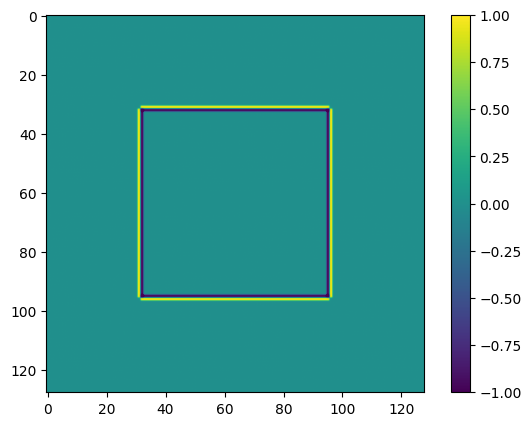

In [105]:
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(initialize_field(NX, NY, NZ, mode="square"))
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(np.zeros((NZ,NY,NX)))
laplacian_taichi_kernel()
out_field = out_field.to_numpy()
plot_field(out_field)

In [106]:
%%timeit in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=0); in_field.from_numpy(in_field_np); out_field_np = np.zeros_like(in_field_np); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(out_field_np)
laplacian_taichi_kernel()

135 µs ± 944 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


True

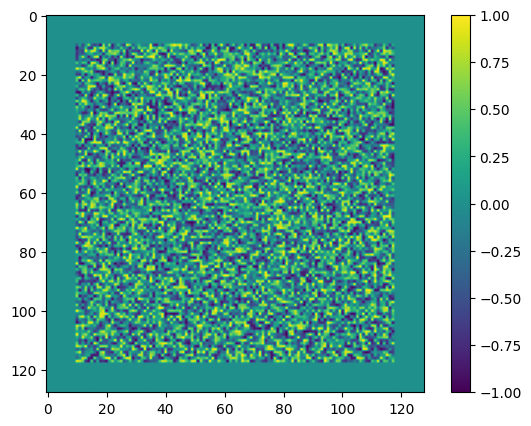

In [107]:
out_field_np = initialize_field(NX, NY, NZ, num_halo=10)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)
plot_field(out_field_np)
copy_out_field = out_field.to_numpy()
np.array_equal(out_field_np, copy_out_field)

False

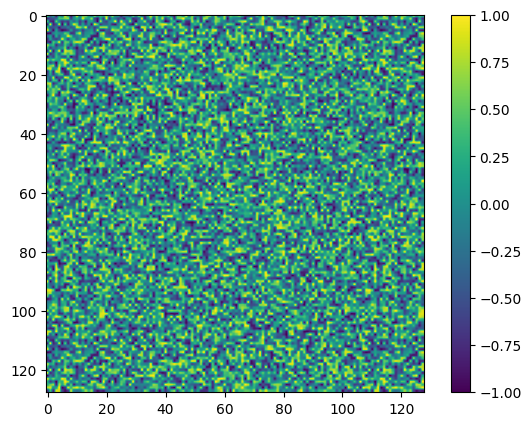

In [108]:
update_halo(out_field_np, num_halo=10)
plot_field(out_field_np)
np.array_equal(out_field_np, copy_out_field)

True

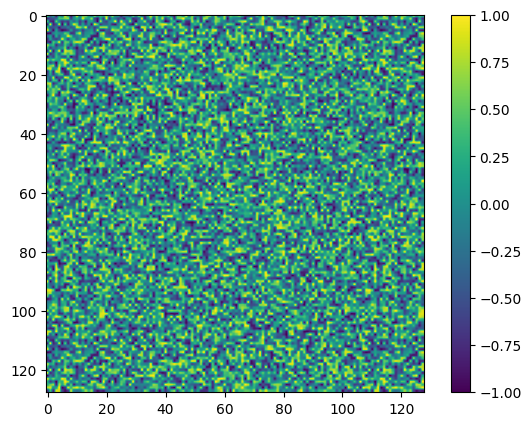

In [109]:
num_halo = 10
update_halo_taichi_kernel()
plot_field(out_field.to_numpy())
np.array_equal(out_field_np, out_field.to_numpy())

In [110]:
#timeit decorator seems to have a conflict with Taichi, so we split them to two blocks
ti.init(arch=ti.gpu, default_fp=ti.f64)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(initialize_field(NX, NY, NZ, num_halo=2))
num_halo = 2

[Taichi] Starting on arch=cuda


In [111]:
%%timeit 
update_halo_taichi_kernel()

135 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [112]:
ti.init(arch=ti.cpu, default_fp=ti.f64)
in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=2)
in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
in_field.from_numpy(in_field_np)

out_field_np = np.zeros_like(in_field_np)
out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
out_field.from_numpy(out_field_np)

tmp_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX))
tmp_field.from_numpy(out_field_np)

out_field_np = apply_diffusion(in_field_np, num_halo=2, num_iter=N_ITER)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

np.allclose(out_field.to_numpy(), out_field_np, rtol=1e-5, atol=1e-8, equal_nan=True)

[Taichi] Starting on arch=x64


True

In [113]:
%%timeit -o in_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); in_field_np = initialize_field(NX, NY, NZ, mode="square", num_halo=0); in_field.from_numpy(in_field_np); out_field_np = np.zeros_like(in_field_np); out_field = ti.field(dtype=ti.f64, shape=(NZ, NY, NX)); out_field.from_numpy(out_field_np)
apply_diffusion_taichi(in_field, out_field, num_halo=2, num_iter=N_ITER)

144 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 144 ms ± 642 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [114]:
result_taichi_gpu_2D = _
save_result(result_taichi_gpu_2D, "taichi_gpu_2D")

In [115]:
taichi_vs_numpy = compare_results(result_taichi_gpu_2D.average, time_numpy_2D)
taichi_gpu_vs_taichi_cpu = compare_results(result_taichi_gpu_2D.average, result_taichi_cpu_2D.average)

md(f"""
Using the GPU backend Taichi runs **{taichi_gpu_vs_taichi_cpu} times faster than with the CPU backend
and {taichi_vs_numpy} times faster than the original Python code**. Now it has a comparable performance
with Numba and GT4Py. The introduction of GPU really boosts 2D diffusion stencil computation.
""")


Using the GPU backend Taichi runs **~1.0 times faster than with the CPU backend
and ~7.6 times faster than the original Python code**. Now it has a comparable performance
with Numba and GT4Py. The introduction of GPU really boosts 2D diffusion stencil computation.


In [116]:
md(f"""
| Function                    | Time                                           |
|:----------------------------|-----------------------------------------------:|
| `numpy_2D()`                |  {time_numpy_2D:.1f}s                          |
| `numba_2D()`                |  {time_numba_2D * 1e3:.1f}ms                   |
| `gt4py_ifirst_2D()`         |  {time_gt4py_2D * 1e3:.1f}ms                   |
| `taichi_cpu_2D()`           |  {result_taichi_cpu_2D.average * 1e3:.1f}ms    |
| `taichi_gpu_2D()`           |  {result_taichi_gpu_2D.average * 1e3:.1f}ms    |
""")


| Function                    | Time                                           |
|:----------------------------|-----------------------------------------------:|
| `numpy_2D()`                |  1.1s                          |
| `numba_2D()`                |  16.0ms                   |
| `gt4py_ifirst_2D()`         |  34.8ms                   |
| `taichi_cpu_2D()`           |  143.6ms    |
| `taichi_gpu_2D()`           |  143.7ms    |


With comparison to Numba we can see Taichi and Numba are good at different tasks. Actually, the Taichi official documentation gives their suggestion in the FAQ section:

> **Numba is recommended if your functions involve vectorization of NumPy arrays**. Compared with Numba, Taichi enjoys the following advantages:
> * Taichi provides advanced features, including quantized data types, dataclasses and sparse data structures, and allows you to adjust memory layout flexibly. These features are especially helpful when a program handles massive amounts of data. However, **Numba only performs best when dealing with dense NumPy arrays**.
> * Taichi can run on different GPU backends, **making large-scale parallel programming (such as particle simulation or rendering) much more efficient**. But it would be hard even to imagine writing a renderer in Numba.

Based on these statements, Numba seems to be the better choice over Taichi in our case as it is not a really big stencil, and no special dataclasses or sparse data structure involved.